<span style="font-size:2em;">**International football results from 1872 to 2021**</span>

This dataset has more than 42000 results of men's international football matches from 1972 to 2021. 
It includes different competitions like FIFA World Cup and friendly matches and is divided into two files: **results** and **shootouts**. 

The **results** file is composed of the following variables:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **home_score** - full-time home team score including extra time, not including penalty-shootouts.
- **away_score** - full-time away team score including extra time, not including penalty-shootouts.
- **tournament** - the name of the tournament.
- **city** - the name of the city/town/administrative unit where the match was played.
- **country** - the name of the country where the match was played.
- **neutral** - TRUE/FALSE column indicating whether the match was played at a neutral venue.

The **shootouts** csv has 4 columns:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **winner** - winner of the penalty-shootout.

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

# Descriptive Statistics

Let's load the dataset and look at the descriptive statistics.

In [2]:
results_df = pd.read_csv('../data/raw/results.csv')
shootouts_df = pd.read_csv('../data/raw/shootouts.csv')

Load National football team affiliations.

In [3]:
afc = [team.strip() for team in open('../data/raw/AFC', "r").read().split('\n')]
caf = [team.strip() for team in open('../data/raw/CAF', "r").read().strip().split('\n')]
concacaf = [team.strip() for team in open('../data/raw/Concacaf', "r").read().strip().split('\n')]
conmebol = [team.strip() for team in open('../data/raw/Conmebol', "r").read().strip().split('\n')]
ofc = [team.strip() for team in open('../data/raw/OFC', "r").read().strip().split('\n')]
uefa = [team.strip() for team in open('../data/raw/UEFA', "r").read().strip().split('\n')]

The first 5 international football matches were between Scotland and England.

In [4]:
shootouts_df.head()

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
3,1972-05-19,Thailand,Cambodia,Thailand
4,1973-07-26,Malaysia,Kuwait,Malaysia


In [5]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43086 entries, 0 to 43085
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        43086 non-null  object 
 1   home_team   43084 non-null  object 
 2   away_team   43084 non-null  object 
 3   home_score  43081 non-null  float64
 4   away_score  43081 non-null  float64
 5   tournament  43086 non-null  object 
 6   city        43086 non-null  object 
 7   country     43086 non-null  object 
 8   neutral     43084 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.0+ MB


In [6]:
shootouts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       444 non-null    object
 1   home_team  444 non-null    object
 2   away_team  444 non-null    object
 3   winner     444 non-null    object
dtypes: object(4)
memory usage: 14.0+ KB


In [7]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_score,43081.0,1.743228,1.753982,0.0,1.0,1.0,2.0,31.0
away_score,43081.0,1.183608,1.400620,0.0,0.0,1.0,2.0,21.0


The team that plays at home scores more goals on average. 

There was one game where the home team scored 31 goals and one where the away team scored 21. Before proceeding, let's check which games are we talking about.

In [8]:
results_df[(results_df["home_score"] == 31) | (results_df["away_score"] == 21)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
23917,2001-04-11,Australia,American Samoa,31.0,0.0,FIFA World Cup qualification,Coffs Harbour,Australia,False
27494,2005-03-11,Guam,North Korea,0.0,21.0,EAFF Championship,Taipei,Taiwan,True


I thought these games would be way more in the past!

**Australia vs American Samoa** can be considered a David vs Golias fight. Australia have won 4 OFC Nations cups and 1 AFC Asian cup while American Samoa lost 45 of a total of 51 matches in his entire history.

I haven't heard of the **EAFF Championship** until now, it is a competition in East Asia for nations like China, South Korea and Japan. The current champion is South Korea, coached by Portuguese Paulo Bento :)

Missing values might affect the analysis, so we are going to see if there are any.

In [9]:
results_df.isnull().sum()

date          0
home_team     2
away_team     2
home_score    5
away_score    5
tournament    0
city          0
country       0
neutral       2
dtype: int64

In [10]:
shootouts_df.isnull().sum()

date         0
home_team    0
away_team    0
winner       0
dtype: int64

There are missing values. Since they are few, let's just ignore them by deleting these rows.

In [11]:
results_df.drop(results_df[results_df.isna().any(axis=1)].index, inplace=True)

# Data Processing

First, we are renaming the columns and their values for plotting purposes.

In [12]:
results_df.rename(columns={'date': 'Date', 
                           'home_team': 'Home Team', 
                           'away_team': 'Away Team',
                           'home_score': 'Home Score',
                           'away_score': 'Away Score',
                           'tournament': 'Tournament',
                           'city': 'City',
                           'country': 'Country',
                           'neutral': 'Neutral'}, inplace=True)

shootouts_df.rename(columns={'date': 'Date',
                             'home_team': 'Home Team', 
                             'away_team': 'Away Team',
                             'winner': 'Winner'}, inplace=True)

By creating columns with the outcome of the match along with the winning and losing teams we are having quicker access to the result of the match. 

We are adding some date-related features like year, month and day of week.

In [13]:
results_df['Outcome'] = results_df.apply(lambda x : 'H' if x['Home Score'] > x['Away Score'] 
                                           else ('A' if x['Home Score'] < x['Away Score'] else 'D'),
                                           axis=1)
results_df['Winning Team'] = results_df.apply(lambda x : x['Home Team'] if x['Home Score'] > x['Away Score'] 
                                           else (x['Away Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                           axis=1)
results_df['Losing Team'] = results_df.apply(lambda x : x['Away Team'] if x['Home Score'] > x['Away Score'] 
                                           else (x['Home Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                           axis=1)
results_df['Year'] = pd.DatetimeIndex(results_df['Date']).year
results_df['Decade'] = results_df['Year'].apply(lambda x: x - x % 10)
results_df['Month'] = pd.DatetimeIndex(results_df['Date']).month
results_df['Day of Week'] = pd.DatetimeIndex(results_df['Date']).day_name()

There are two matches with the wrong team order in **results.csv**, it is necessary to correct them to merge **results.csv** and **shootouts.csv** .

In [14]:
results_df["Home Team"].iloc[31849] = "South Africa"
results_df["Away Team"].iloc[31849] = "Zimbabwe"
results_df["Home Team"].iloc[40795] = "Uganda"
results_df["Away Team"].iloc[40795] = "South Africa"

Results_df does not currently include results after penalties, so we are populating the Winning Team column with matches that required penalties to determine the winners.

In [15]:
football_df = results_df.merge(shootouts_df, how="outer", on=['Home Team', 'Away Team', 'Date'])
football_df["Winning Team"] = football_df.apply(
    lambda x: x["Winner"] if not pd.isnull(x["Winner"]) and pd.isnull(x["Winning Team"]) else x["Winning Team"], axis=1)
football_df["Losing Team"] = football_df.apply(
    lambda x: x["Home Team"] if x["Winning Team"] == x["Away Team"] and x["Outcome"] =="D" 
    else x["Away Team"] if x["Winning Team"] == x["Home Team"] and x["Outcome"] =="D" 
    else x["Losing Team"], axis=1)
football_df.drop(columns = ["Winner"], inplace=True)

We should check if the above features were created correctly.

In [16]:
football_df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Tournament,City,Country,Neutral,Outcome,Winning Team,Losing Team,Year,Decade,Month,Day of Week
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,D,NaN,NaN,1872,1870,11,Saturday
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,H,England,Scotland,1873,1870,3,Saturday
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,1874,1870,3,Saturday
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,D,NaN,NaN,1875,1870,3,Saturday
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,1876,1870,3,Saturday


Everything checks out!

Also, we are creating a dataframe with all teams, their first international matches and their affiliations.

In [17]:
affiliations_df = pd.DataFrame({
    'Affiliation' : ['AFC'] * len(afc) + ['CAF'] * len(caf) + ['CONCACAF'] * len(concacaf) + \
    ['CONMEBOL'] * len(conmebol) + ['OFC'] * len(ofc) + ['UEFA'] * len(uefa),
    'Region' : ['Asia'] * len(afc) + ['Africa'] * len(caf) + ['North and Central America'] * len(concacaf) + \
    ['South America'] * len(conmebol) + ['Oceania'] * len(ofc) + ['Europe'] * len(uefa),
    'Team': afc + caf + concacaf + conmebol + ofc + uefa
})

In [20]:
all_teams = list(football_df["Home Team"].unique())
all_teams.extend(list(football_df["Away Team"].unique()))
all_teams_df = pd.DataFrame({'Team': list(set(all_teams))})
all_teams_df["First Game Year"] = all_teams_df["Team"].apply(lambda x: football_df[(football_df['Home Team'] == x) | (football_df['Away Team'] == x)].head(1)['Year'].values[0])
all_teams_df['First Game Decade'] = all_teams_df["First Game Year"].apply(lambda x: x - x % 10)
all_teams_df = all_teams_df.merge(affiliations_df, how="left", on=['Team'])
all_teams_df.sort_values(by="First Game Year", inplace=True)

Lastly, let's create a list with the days of week ordered, which will come in handy during the analysis.

In [231]:
week_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

We are ready to plot!

# Data Visualization

Let's go through the rest of this notebook creating different charts to answer a few questions.

**How has the adoption of football been over time?**

Number of new teams per decade.

In [78]:
total_new_teams_per_decade = all_teams_df["First Game Decade"].value_counts().sort_index()

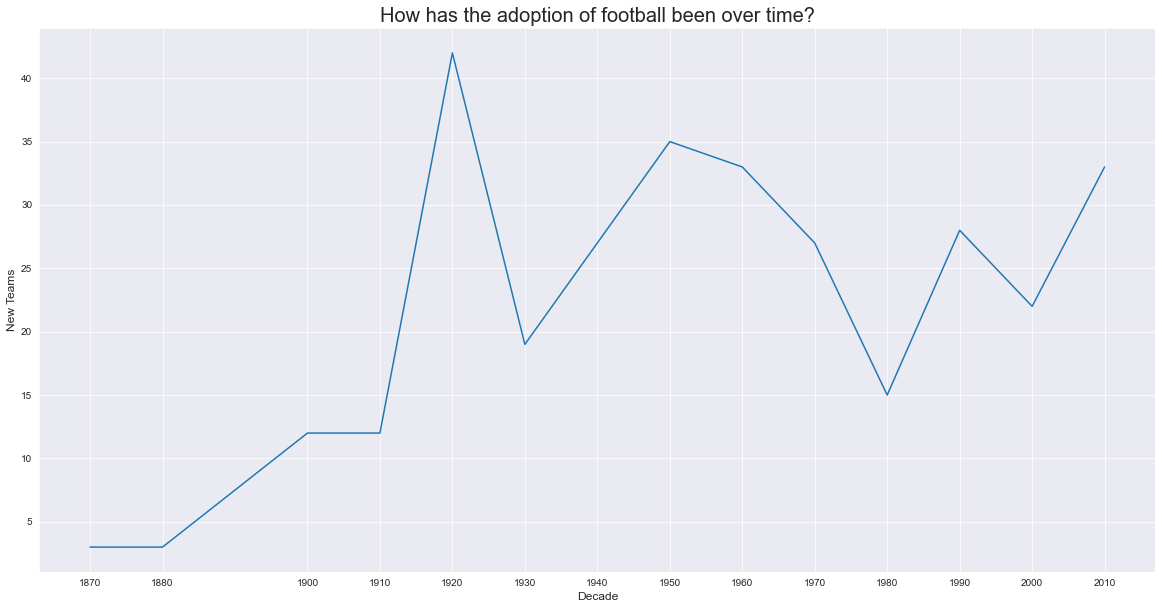

In [76]:
plt.figure(figsize=(20,10))
# ax = sns.lineplot(data=total_new_teams_per_decade_per_region, x="First Game Decade", y="Count", hue="Region")
ax = sns.lineplot(data=total_new_teams_per_decade, x=total_new_teams_per_decade.index, y=total_new_teams_per_decade.values)
ax.set_title('How has the adoption of football been over time?', size=20)
ax.set_xlabel(xlabel='Decade', size=12)
ax.set_ylabel(ylabel='New Teams', size=12)
ax.set(xticks=new_teams_per_decade.index);

The number of teams steadily increased 1902 and this increase accelerated up to 1920.

From there, the pace of addition of new teams increase much faster and stalls abit around the late 40's

Then we see a steady and rapid growth up to the mid 1990's.

In [130]:
total_new_teams_per_decade_per_region = all_teams_df[["First Game Decade", "Region"]].value_counts().sort_index().reset_index(level=1)
total_new_teams_per_decade_per_region.rename(columns={0: 'Count'}, inplace=True)

In [135]:
total_new_teams_per_decade_per_region = pd.pivot(total_new_teams_per_decade_per_region,columns='Region', values='Count')

Text(0, 0.5, 'Matches')

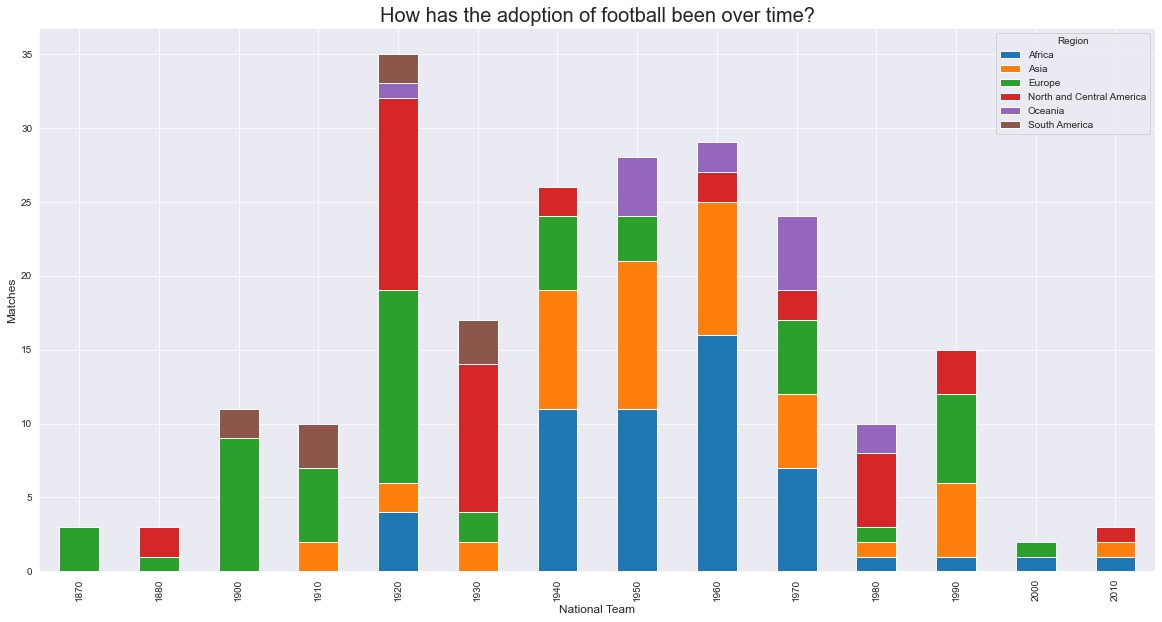

In [137]:
ax = total_new_teams_per_decade_per_region.plot(kind="bar", stacked=True, figsize=(20,10))
ax.set_title("How has the adoption of football been over time?", size=20)
ax.set_xlabel(xlabel="National Team", size=12)
ax.set_ylabel(ylabel="Matches", size=12)

Europe was the first continent to provide many soccer teams, followed by the American continent (North and South) in the 1880's. Between 1920 and 1940, the Americas even had a stronger growth than Europe. The recent rapid growth period in Europe are likely explained by the birth of new countries, such as the ex-Yugoslavia derived countries in the 1990's. Oceania and Asia started a bit later, around the 1920's and Africa was the last continent to join in the mid 20's but then saw a very rapid growth until the mid 1970's.

**How many matches per year?**

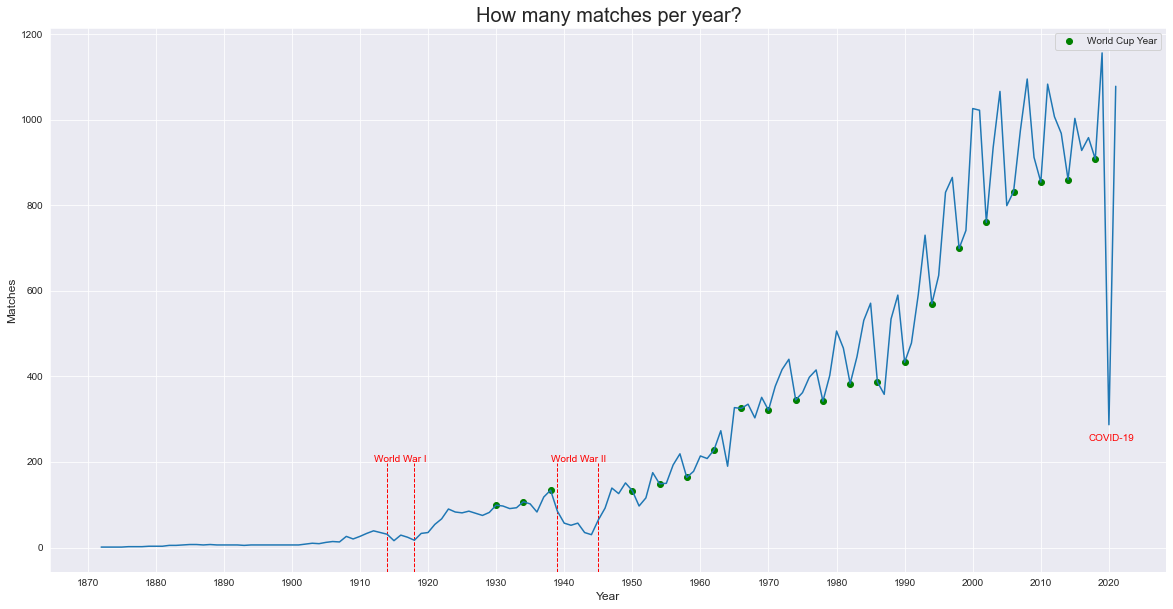

In [191]:
games_per_year = football_df["Year"].value_counts().sort_index()
games_per_decade = football_df["Decade"].value_counts().sort_index()

world_cup_year_games = games_per_year[games_per_year.index.isin(football_df[football_df["Tournament"] == "FIFA World Cup"]["Year"].unique())]

plt.figure(figsize=(20,10))

# Mark world wars years
plt.axvline(x = 1914, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.axvline(x = 1918, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.text(1912, 200, 'World War I', color="red"); 
plt.axvline(x = 1939, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.axvline(x = 1945, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.text(1938, 200, 'World War II', color="red"); 
plt.plot(world_cup_year_games, 'go', label="World Cup Year")
plt.text(2017, 250, 'COVID-19', color="red"); 

# ax = sns.lineplot(data=total_new_teams_per_decade_per_region, x="First Game Decade", y="Count", hue="Region")
ax = sns.lineplot(data=games_per_year, x=games_per_year.index, y=games_per_year.values)
ax.set_title('How many matches per year?', size=20)
ax.set_xlabel(xlabel='Year', size=12)
ax.set_ylabel(ylabel='Matches', size=12)
ax.set(xticks=games_per_decade.index);

**How many matches per month?**

In [208]:
games_per_month = football_df[["Month", "Year"]].value_counts().reset_index().sort_values(by=["Month", "Year"])

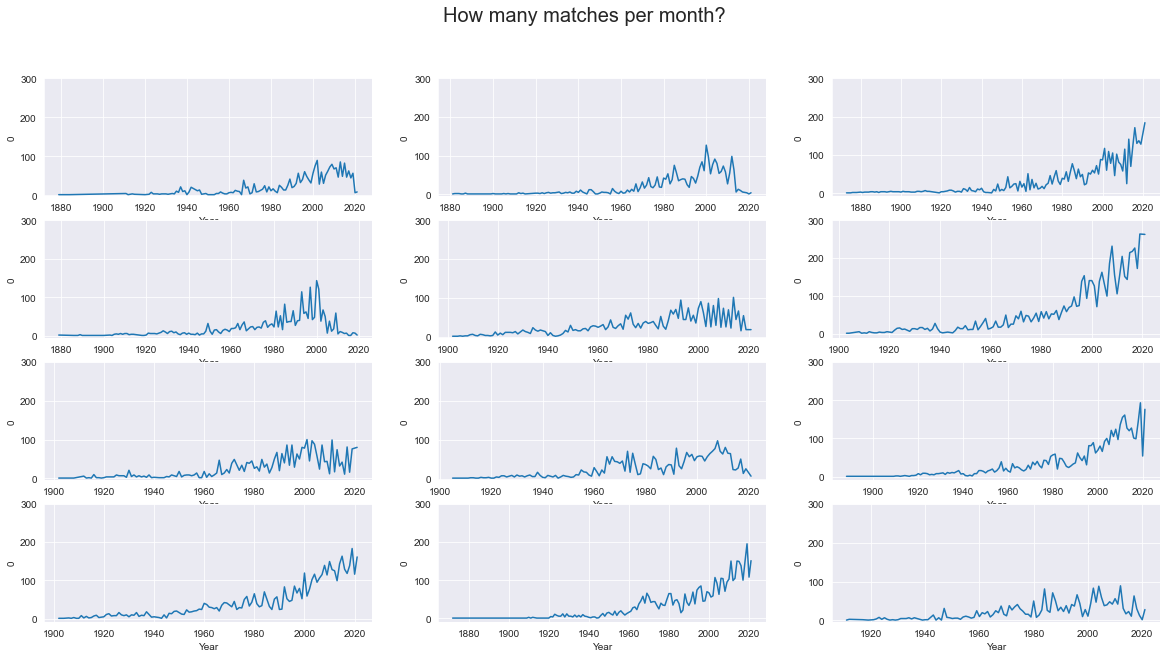

In [221]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20,10))
index = 0
ax = ax.flatten()

for value in games_per_month["Month"].unique():
    sns.lineplot(data=games_per_month[games_per_month["Month"] == value], x="Year", y=0, ax=ax[index])
    ax[index].set_ylim(top=300)
    index+=1

fig.suptitle("How many matches per month?", fontsize=20);

The first games mostly occur during Spring months and since then, some month have known some peaks of popularity for intenational games at different period (e.g. many games happened in December in the 1940s). In a more recent history, international games became less common in May but more in June.

**How many matches per day of week?**

In [228]:
games_per_dow = football_df[["Day of Week", "Year"]].value_counts().reset_index().sort_values(by=["Year"])

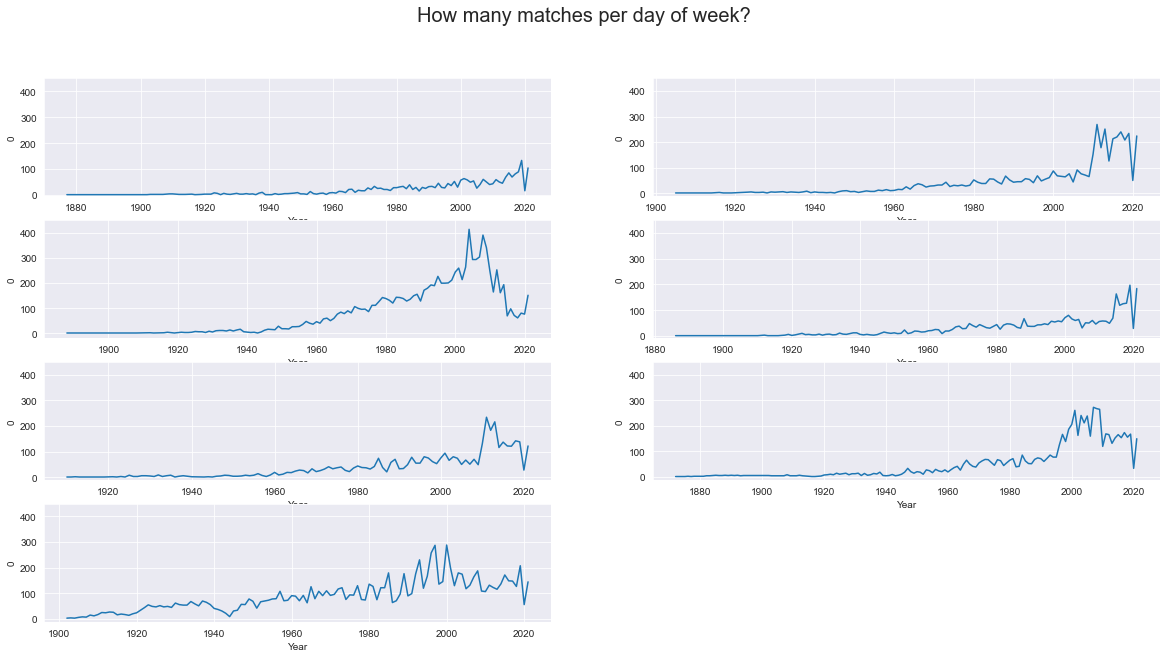

In [241]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20,10))
index = 0
ax = ax.flatten()

for value in week_days:
    sns.lineplot(data=games_per_dow[games_per_dow["Day of Week"] == value], x="Year", y=0, ax=ax[index])
    ax[index].set_ylim(top=450)
    index+=1

fig.delaxes(ax[7]) #The indexing is zero-based here
fig.suptitle("How many matches per day of week?", fontsize=20);

Interstingly, the very first games mostly occur on Saturdays but a decent number also took place on Mondays! No game occurred on a Sunday until 1900, potentially for religious purposes but, around the 1910's Sunday was the most common day of the week to see an international game. Other week days, from Tuesday to Friday, weren't an option until later (as late as 1910 for Fridays).

The proportion of games happenning on a given day then changed quite a lot. Wednesdays games became very common and around 30% of the games happened on this day around the year 2000. More recently days such as Tuesday, Thursday or Friday also became more popular.

**Which cities hosted most games?**

In [262]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="location script")

def func(x):
    city = x["City"]
    location = geolocator.geocode(city)
    if location is None:
        location = geolocator.geocode(city.title())
    if location is None:
        return None
    return [location.latitude, location.longitude]


football_cities_df = pd.DataFrame(football_df["City"].value_counts().sort_values(ascending=False).reset_index())
football_cities_df.rename(columns={'index': 'City', 'City': 'Count'}, inplace=True)
football_cities_df[["Latitude", "Longitude"]] = football_cities_df.apply(lambda x: func(x), axis=1, result_type='expand')

In [277]:
import folium

m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

for index, value in football_cities_df.iterrows():
    if not pd.isnull(value['Latitude']) and not pd.isnull(value['Longitude']):
        folium.Circle(
          location=[value['Latitude'], value['Longitude']],
          popup=value["City"],
          radius=float(value["Count"]) * 1000,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
m

A large part of the larger bubbles can be seen in capitals, which was to be expected.

**Which city is better for home country?**

In [290]:
home_team_wins_by_city = pd.DataFrame(
    football_df[(football_df["Neutral"] == False) & (football_df["Home Team"] == football_df["Winning Team"])][["Home Team", "City"]].value_counts().reset_index())
home_team_wins_by_city.head(50)

,Home Team,City,0
0,Hungary,Budapest,227
1,England,London,221
2,Scotland,Glasgow,187
3,Denmark,Copenhagen,184
4,Uruguay,Montevideo,174
5,Austria,Vienna,172
6,Argentina,Buenos Aires,169
7,Republic of Ireland,Dublin,140
8,Sweden,Solna,137
9,Romania,Bucharest,136


**Which tournaments had the most games?**

To answer this, we are excluding friendly matches, qualifiers and tournaments with less than 100 matches.

In [141]:
tournament_counts = pd.DataFrame(football_df["Tournament"].value_counts().reset_index()) \
    .rename(columns={'index': 'Tournament', 'Tournament': 'Count'})

tournament_counts = tournament_counts[(tournament_counts["Tournament"] != "Friendly") & 
                                      (~ tournament_counts["Tournament"].str.endswith('qualification')) & 
                                      (tournament_counts["Count"] >= 100)]
tournament_counts.reset_index(inplace=True)

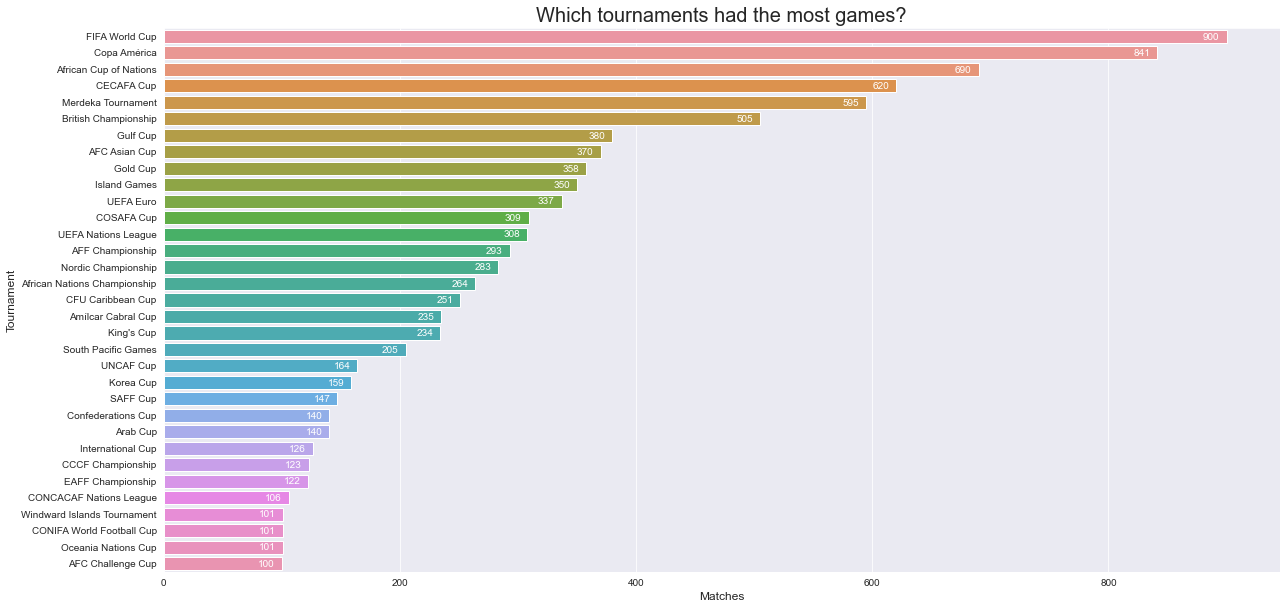

In [87]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=tournament_counts["Tournament"], x=tournament_counts["Count"], orient='h')
ax.set_title("Which tournaments had the most games?", size=20)
ax.set_xlabel(xlabel="Matches", size=12)
ax.set_ylabel(ylabel="Tournament", size=12)

# Annotate value labels to each team
for index, value in tournament_counts.iterrows(): 
    plt.annotate(value['Count'], xy=(value['Count'] - 20, index + 0.2), color='white')

We will consider two competitions played between teams from all continents (World Cup and Confederations Cup) and the main competitions of each continent. So, these are the tournaments in the dataset that we will take as the main ones:
- FIFA World Cup
- Confederations Cup
- Copa América
- African Cup of Nations
- African Nations Championship	
- AFC Asian Cup
- Gold Cup
- CONCACAF Nations League
- UEFA Euro
- UEFA Nations League
- Oceania Nations Cup

Now we are ready to look at the top 10 of the teams that have played the most games in major tournaments.

**Which national teams have played the most games in major tournaments?**

In [88]:
major_tournaments = ['FIFA World Cup', 'Confederations Cup', 'Copa América', 'African Cup of Nations', 
                     'African Nations Championship', 'AFC Asian Cup', 'Gold Cup', 'CONCACAF Nations League', 
                     'UEFA Euro', 'UEFA Nations League', 'Oceania Nations Cup']

major_tournaments_df = football_df[football_df["Tournament"].isin(major_tournaments)]

In [89]:
home_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Home Team"].value_counts()

neutral_team_game_counts = pd.concat([major_tournaments_df[major_tournaments_df["Neutral"] == True]["Home Team"].value_counts(),
           major_tournaments_df[major_tournaments_df["Neutral"] == True]["Away Team"].value_counts()], axis=1)
neutral_team_game_counts["Neutral"] = neutral_team_game_counts["Home Team"] + neutral_team_game_counts["Away Team"]

away_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Away Team"].value_counts()

game_counts = pd.concat([home_team_game_counts, neutral_team_game_counts["Neutral"], away_team_game_counts], axis=1)
game_counts["Total"] = game_counts["Home Team"] + game_counts["Neutral"] + game_counts["Away Team"]
game_counts_top10 = game_counts.sort_values(by="Total", ascending=False).head(10)

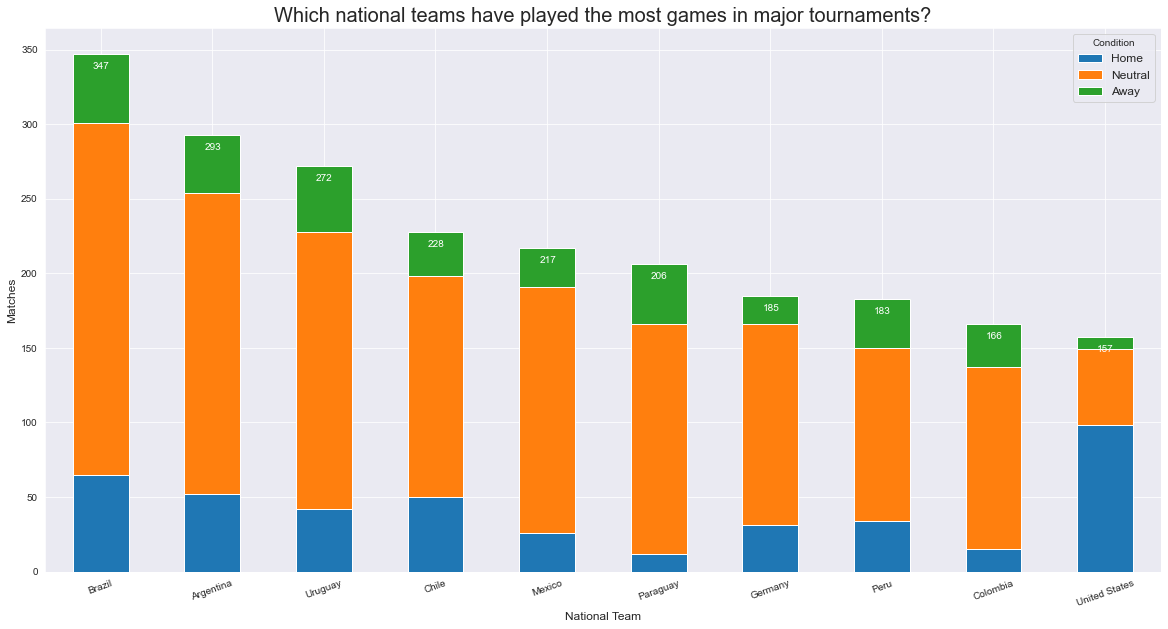

In [90]:
ax = game_counts_top10[["Home Team", "Neutral", "Away Team"]].plot(kind="bar", stacked=True, figsize=(20,10))
ax.set_title("Which national teams have played the most games in major tournaments?", size=20)
ax.set_xlabel(xlabel="National Team", size=12)
ax.set_ylabel(ylabel="Matches", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20);
ax.legend(["Home", "Neutral", "Away"], loc="upper right", title="Condition", fontsize=12);

# Annotate value labels to each team
i = 0
for index, value in game_counts_top10.iterrows(): 
    plt.annotate(int(value['Total']), xy=(i - 0.07, value['Total'] - 10), color='white')
    i += 1

It makes sense that teams from **South America (Brazil, Argentina, Uruguay, Chile, Paraguay, Peru and Colombia)** dominate this top 10. Copa América is the second most played tournament among the considered as major. Plus, the top 3 (Brazil, Argentina and Uruguay) add up to nine World Cups,  thirty nine Copa Américas, and five Confederations Cups!

Brazil, Colombia and Peru were invited to the Gold Cup. In three editions, Brazil was runner-up twice and third once. Colombia also played three times, reaching the final once and Peru reached the semifinals the only time they played in this competition.

**Mexico** is the most powerful team in the CONCACAF region. Mexico has won eleven Gold Cups and one Confederations Cup.

**Germany** is the only European team that appears, which is explained by the fact that it is the most successful European team. It has won four World Cups, three Euros and one Confederations Cup. 

**United States** has won seven Gold Cups and one CONCACAF Nations League (there has been only one edition). The high number of home games for the United States is due to having been the hosts or co-hosts of all editions of the Gold Cup. 

Mexico and the United States have participated in 10 and 4 editions of the Copa América. Mexico achieved two second places and three third places, while the United States finished fourth twice. This also contributed to the high number of games played by these two nations.

**Which teams have the best win ratio in major tournaments?**

In [91]:
win_ratios = pd.concat([major_tournaments_df["Winning Team"].value_counts(), game_counts["Total"]], axis=1)
win_ratios["Ratio"] = win_ratios["Winning Team"] / win_ratios["Total"]

Before plotting, let's look at the statistics of the win_rations to define a threshold at the number of total games. It isn't fair to consider a team with few games the best win ratio, is it?

In [92]:
win_ratios.describe()

,Winning Team,Total,Ratio
count,182.000000,124.000000,120.000000
mean,19.521978,64.580645,0.344213
std,30.829187,61.921416,0.142338
min,1.000000,6.000000,0.062500
25%,3.000000,21.000000,0.241956
50%,7.000000,45.000000,0.349548
75%,22.750000,85.250000,0.436159
max,220.000000,347.000000,0.666667


25% of the teams have less than 21 games, I think that is a good threshold. 

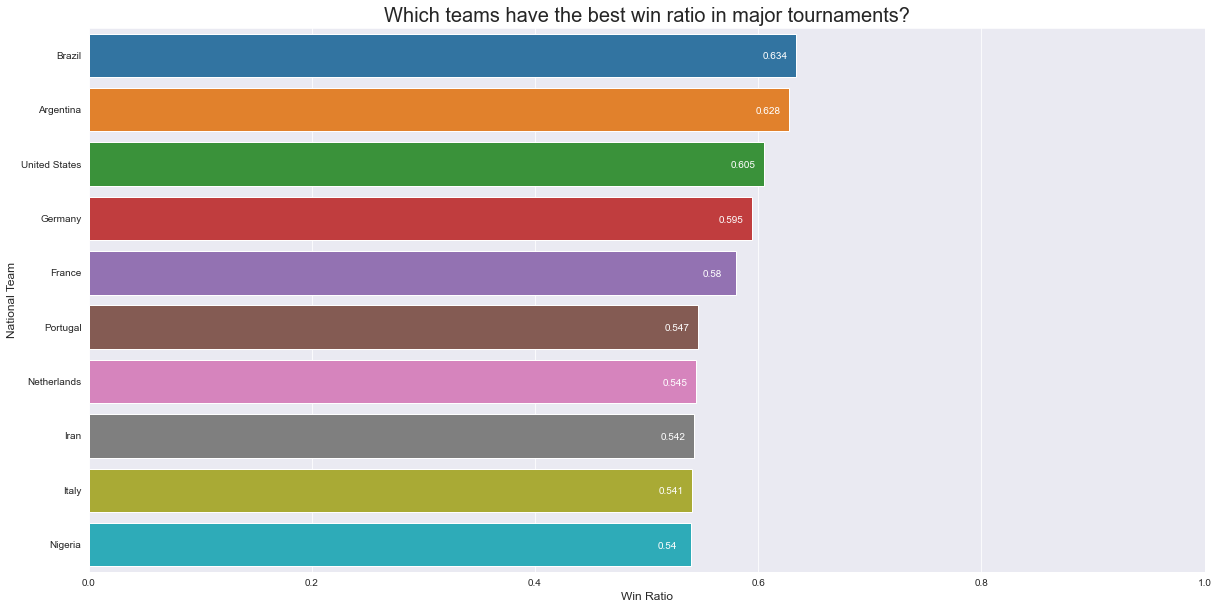

In [93]:
win_ratios = win_ratios[win_ratios["Total"] > 21]
win_ratios_top_10  = win_ratios.sort_values(by="Ratio", ascending=False).head(10)

plt.figure(figsize=(20,10))
ax = sns.barplot(x=win_ratios_top_10["Ratio"], y=win_ratios_top_10.index, orient='h')
ax.set_title("Which teams have the best win ratio in major tournaments?", size=20)
ax.set_xlabel(xlabel="Win Ratio", size=12)
ax.set_ylabel(ylabel="National Team", size=12)
ax.set_xlim(right=1)

# Annotate value labels to each team
i = 0
for index, value in win_ratios_top_10.iterrows(): 
    plt.annotate(float("{:.3f}".format(value['Ratio'])), xy=(value['Ratio']-0.03, i+0.075), color='white')
    i += 1

One of the fiercest rivalries in the history of football stands on top: Brazil and Argentina. 

Note that 5 of the 10 teams are European: Germany, France, Portugal, Netherlands and Italy.

United States, Iran and Nigeria aren't the teams with most titles in their regions but they usually go far, which explains the high win ratio.

**Which are the best teams per decade in major tournaments?**

Let's find out the golden eras of the best national teams. 

In [94]:
win_ratio_per_decade = pd.concat(
    [pd.DataFrame(major_tournaments_df.groupby('Decade')['Winning Team'].apply(lambda x: x.value_counts())),
     pd.DataFrame(major_tournaments_df.groupby('Decade')['Home Team'].apply(lambda x: x.value_counts())),
     pd.DataFrame(major_tournaments_df.groupby('Decade')['Away Team'].apply(lambda x: x.value_counts()))],
    axis=1)

win_ratio_per_decade["Total"] = win_ratio_per_decade['Home Team'] + win_ratio_per_decade['Away Team']
win_ratio_per_decade["Ratio"] = win_ratio_per_decade['Winning Team'] / win_ratio_per_decade["Total"]

win_ratio_per_decade = win_ratio_per_decade[win_ratio_per_decade["Total"] > 5]
win_ratio_per_decade_top_3 = win_ratio_per_decade.sort_values(by=["Decade", "Ratio"], axis=0, na_position="first").groupby(level=0).tail(3)
win_ratio_per_decade_top_3 = win_ratio_per_decade_top_3.reset_index()

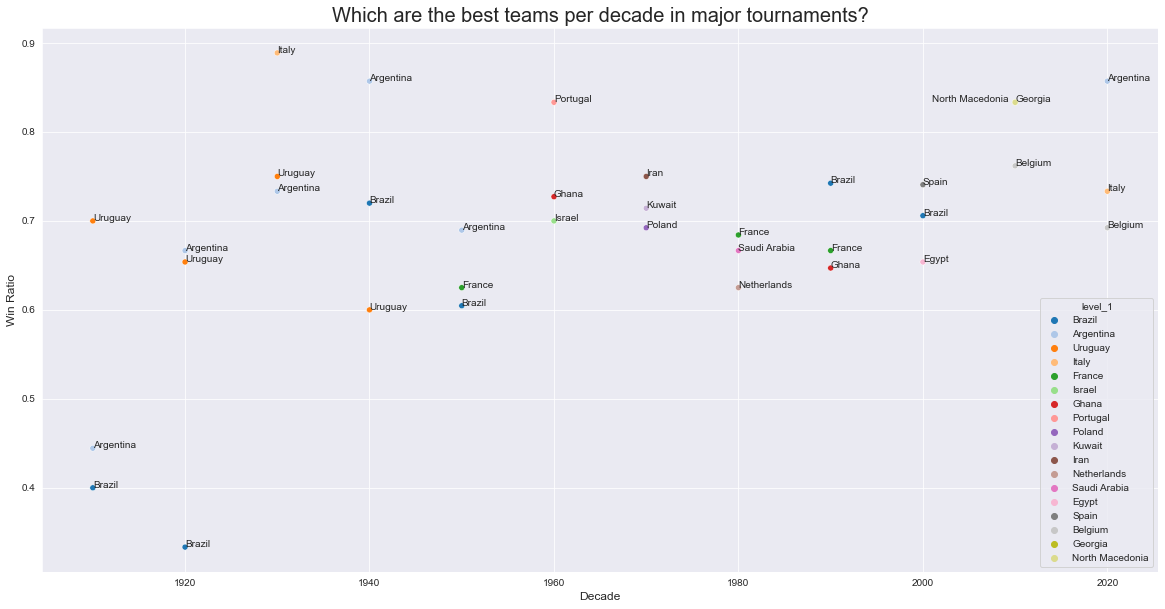

In [95]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = 'Decade', y = 'Ratio', hue ='level_1', data=win_ratio_per_decade_top_3, palette="tab20")
ax.set_title("Which are the best teams per decade in major tournaments?", size=20)
ax.set_xlabel(xlabel="Decade", size=12)
ax.set_ylabel(ylabel="Win Ratio", size=12)

# Annotate the top 3 national teams
for index, row in win_ratio_per_decade_top_3.iterrows():
    if row["Decade"] == 2010 and row["level_1"] == "North Macedonia":
        plt.annotate(row['level_1'], xy=(row['Decade'] - 9, row['Ratio']), fontsize=10)
    else:
        plt.annotate(row['level_1'], xy=(row['Decade'], row['Ratio']), fontsize=10)